In [15]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation
import numpy as np
from matplotlib import pyplot as plt


In [2]:
import os

In [3]:
os.getcwd()

'/home/dadubovs/projects/deep_query_optimization/dqo/estimator/neo'

In [4]:
root_path = "/home/dadubovs/projects/deep_query_optimization/"

import sys
sys.path.insert(0, root_path)

In [5]:
from dqo.estimator.neo.query_estimator import NeoQueryEstimator

import os

schema_file = os.path.join(root_path, 'dqo/data/job/data/schematext.sql')

In [6]:
input_path = os.path.join(root_path, 'dqo/data/input/sql/fast/')

In [7]:
input_path = os.path.join(root_path, 'dqo/data/input/sql/slow/')

In [8]:
neo = NeoQueryEstimator(input_path, schema_file=schema_file)

In [9]:
neo.load_db_schema()

In [10]:
neo.encode_data()

Reading data from /home/dadubovs/projects/deep_query_optimization/dqo/data/input/sql/slow/slow_query_log.csv
Reading data from /home/dadubovs/projects/deep_query_optimization/dqo/data/input/sql/slow/slow_query_log.csv.1
Reading data from /home/dadubovs/projects/deep_query_optimization/dqo/data/input/sql/slow/slow_query_log.csv.2
Reading data from /home/dadubovs/projects/deep_query_optimization/dqo/data/input/sql/slow/slow_query_log.csv.3
Saved temp data file /tmp/dqo/estimator/NeoQueryEstimator/encoded/slow_query_log_train.csv with 41486 records
Saved temp test file /tmp/dqo/estimator/NeoQueryEstimator/encoded/slow_query_log_test.csv with 10372 records
Encoded 51858 queries


In [12]:

# demonstrate data standardization with sklearn
from sklearn.preprocessing import StandardScaler
# load data
#data = ...
# create scaler
Y_train_scaler = StandardScaler()
# fit and transform in one step stn.norm_runtime_train
neo.Y_train = Y_train_scaler.fit_transform(neo.train_data.runtime.values.reshape(-1, 1))
# inverse transform
# inverse = Y_train_scaler.inverse_transform(standardized)
Y_test_scaler = StandardScaler()
neo.Y_test = Y_test_scaler.fit_transform(neo.test_data.runtime.values.reshape(-1, 1))

In [13]:
neo.X_train = np.vstack(neo.train_data.input.values)
neo.X_test = np.vstack(neo.test_data.input.values)

In [17]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Dense(64, input_dim=318, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

neo.model = model

In [18]:
#callbacks = []
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)]

neo.history = neo.model.fit(
    neo.X_train,
    neo.Y_train,
    epochs=20,
    verbose=1,
    validation_split=0.20,
    callbacks=callbacks
)

Train on 33188 samples, validate on 8298 samples
Epoch 1/20
33188/33188 [==============================] - 11s 321us/sample - loss: 0.9573 - accuracy: 0.0000e+00 - mae: 0.3059 - mse: 0.9573 - val_loss: 0.8766 - val_accuracy: 0.0000e+00 - val_mae: 0.2696 - val_mse: 0.8766
Epoch 2/20
33188/33188 [==============================] - 9s 271us/sample - loss: 0.8166 - accuracy: 0.0000e+00 - mae: 0.2855 - mse: 0.8166 - val_loss: 0.8099 - val_accuracy: 0.0000e+00 - val_mae: 0.2965 - val_mse: 0.8099
Epoch 3/20
33188/33188 [==============================] - 9s 263us/sample - loss: 0.5925 - accuracy: 0.0000e+00 - mae: 0.2611 - mse: 0.5925 - val_loss: 0.7510 - val_accuracy: 0.0000e+00 - val_mae: 0.2636 - val_mse: 0.7510
Epoch 4/20
33188/33188 [==============================] - 9s 270us/sample - loss: 0.4544 - accuracy: 0.0000e+00 - mae: 0.2379 - mse: 0.4544 - val_loss: 0.7316 - val_accuracy: 0.0000e+00 - val_mae: 0.2441 - val_mse: 0.7316
Epoch 5/20
33188/33188 [==============================] - 9s 2

In [19]:
history = neo.history

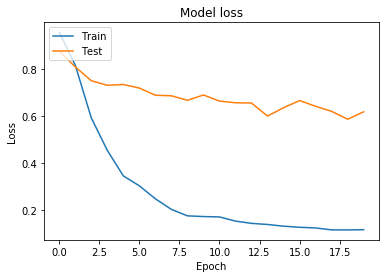

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
predicted = Y_train_scaler.inverse_transform(neo.model.predict(neo.X_train))
predictions = []
actual = []
diff = []
ratio = []

for i in range(len(predicted)):
    pred = float(predicted[i])
    act = float(neo.train_data.runtime.values[i])
    pred = max(pred,0.001)
    predictions.append(pred)
    actual.append(act)
    diff.append(max(np.abs(pred - act), 0.001))
    ratio.append(max(pred,act,0.001) / max(min(pred,act),0.001))



In [23]:
from scipy import stats
stats.describe(diff)

DescribeResult(nobs=41486, minmax=(0.001, 300.4515362381935), mean=2.9497185220871898, variance=67.82713794059376, skewness=18.664022419052415, kurtosis=563.7345446004315)

In [24]:
from scipy import stats
stats.describe(ratio)

DescribeResult(nobs=41486, minmax=(1.000023497305761, 104873.94261360168), mean=146.51704873173597, variance=918639.7921223767, skewness=52.223939058380346, kurtosis=4332.936353954178)

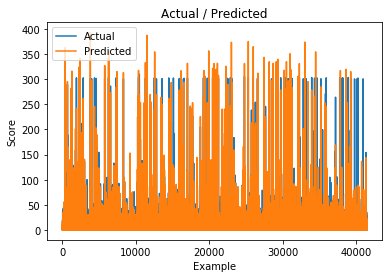

In [25]:
# Plot training & validation loss values
plt.plot(actual)
plt.plot(predictions)
plt.title('Actual / Predicted')
plt.ylabel('Score')
plt.xlabel('Example')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()